In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import numpy as np
import pandas as pd
import time
import pickle
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# local imports
import utils

# general settings  
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', size=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
### parameters
subset_string = 'subset1'
met = 'dp' # 'acc' 'dp' 'eqacc'
subset = utils.get_subset(subset_string)
# remove PR from states
states = sorted(list(set(utils.states)-{'PR'}))
nstates = len(states)
print('nstates', nstates)
state2pos = {s:i for i, s in enumerate(states)}

nstates 50


In [3]:
# load distances (see calculate_distances.ipynb)
dists = pickle.load( open("results/distances.pkl", "rb" ) )
# restrict to subset and states
dists = { k:{att:d for att, d in v.items() if att in subset} for k, v in dists.items() if k[0] in states and k[1] in states}

In [4]:
import glob

# load results
results = []
for filename in glob.glob("results/min_cases_5percent_" + met + "/results_*.pkl"):
    print(filename)
    result = pickle.load( open( filename, "rb" ) )
    results.extend(result)

results/min_cases_5percent_dp\results_0_1_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_10_11_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_11_12_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_12_13_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_13_14_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_14_15_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_15_16_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_16_17_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_17_18_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_18_19_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_19_20_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_1_2_subset1_demographic_parity.pkl
results/min_cases_5percent_dp\results_20_21_subset1_demographic_parity.pkl
results/min_cases_5percent_dp

In [5]:
len(results)

5202

In [6]:
# find specific results
def cond(l, source=None, target=None, alpha=1, subset=subset):
    return [r for r in l if (source is None or (r['source']==source)) and\
            (target is None or (r['target']==target)) and\
            (r['alpha']==alpha) and (r['subset']==subset)]

# build metric matrix
def metric_m(m='acc', alpha=0, kind='alpha_rel', diag=False):
    res = np.zeros((nstates, nstates))
    for i, source in enumerate(states):
        for j, target in enumerate(states):
            if i==j and not diag:
                res[i, j] = np.NaN
                continue
            target_target = cond(results, source=target, target=target, alpha=None)
            source_target = cond(results, source=source, target=target, alpha=None)
            source_target_alpha = cond(results, source=source, target=target, alpha=alpha)
            if len(target_target)==1 and len(source_target)==1 and len(source_target_alpha)==1:
                target_target_v = utils.get_metric(target_target[0], m)
                source_target_v = utils.get_metric(source_target[0], m)
                source_target_alpha_v = utils.get_metric(source_target_alpha[0], m)
                mi = min(target_target_v, source_target_v)
                ma = max(target_target_v, source_target_v)
                if kind=='alpha_rel':
                    if mi  != ma:
                        rel = (source_target_alpha_v-mi)/(ma  - mi)*100
                        res[i, j] = (rel if rel >= -100 else -100) if rel <= 100 else 100
                    else:
                        res[i, j] = 100 if source_target_alpha_v >= mi else -100
                elif kind=='alpha_abs':
                    res[i, j] = (source_target_alpha_v - target_target_v)*100
                elif kind=='st_abs':
                    res[i, j] = (source_target_v - target_target_v)*100
                else:
                    raise BaseException("unknown kind", kind)
            else:
                raise BaseException("error {} {} {} {}".format(source, target, len(target_target), len(source_target), len(source_target_alpha)))
    return res

st_abs = metric_m(m = met, kind='st_abs')
alpha_0_rel = metric_m(m = met, kind='alpha_rel')
alpha_0_abs = metric_m(m = met, kind='alpha_abs')

1.7784690704329278
Ttest_1sampResult(statistic=13.323789308342128, pvalue=3.753686483527504e-39)
1.1037889906576601
Ttest_1sampResult(statistic=7.778037927509931, pvalue=1.076756865559253e-14)


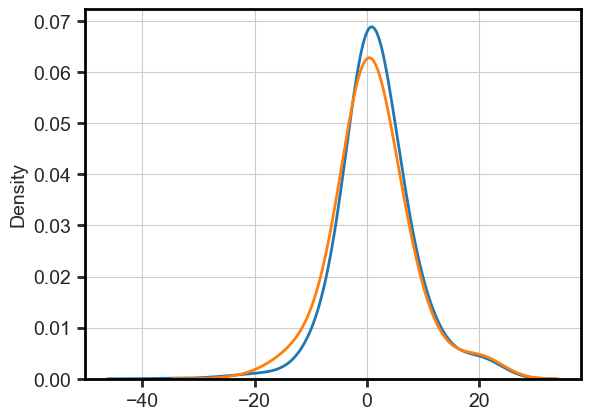

In [7]:
from scipy import stats

data1 = st_abs.flatten()
data1 = data1[~np.isnan(data1)]
print(np.mean(data1))
print(stats.ttest_1samp(data1, popmean=0))
sns.kdeplot(np.array(data1), bw_method=0.5)

data2 = alpha_0_abs.flatten()
data2 = data2[~np.isnan(data2)]
print(np.mean(data2))
print(stats.ttest_1samp(data2, popmean=0))
sns.kdeplot(np.array(data2), bw_method=0.5)
plt.show()

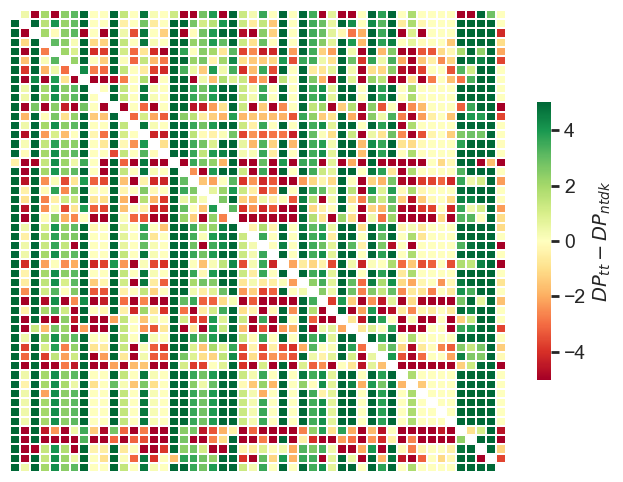

In [8]:
label = "$ACC_{tt}-ACC_{ntdk}$" if met=='acc' else "$DP_{tt}-DP_{ntdk}$"
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(st_abs,xticklabels=False, yticklabels = False, #row_cluster=cluster, col_cluster=cluster,
                    cbar_kws={'label': label, 'shrink':0.6}, center=0, vmin=-5, vmax=5,
                    linewidths= 0.25, cmap="RdYlGn")
plt.savefig('fig2'+met+'.png', bbox_inches='tight', dpi=400)
plt.show()

In [9]:
%%time

# compute dimensions of analysis
def sim(k, d, agg=np.mean, att=None):
    atts = dists[k]
    if att is None:
        return agg([v[d] for v in atts.values()])
    return atts[att][d]

res = []
for k in dists:
    sr, tg = k
    if sr in states and tg in states and sr != tg:
        res.append(
            { 'source':sr, 
              'target':tg,
              'avg_d_att':sim(k, 'd_att'),
              'avg_d_y_cond':sim(k, 'd_y_cond'),
              'avg_d_splits':sim(k, 'd_splits'),
              'min_d_y_cond':sim(k, 'd_y_cond', np.min),
              'tree_w_cond_dist_no_corr':cond(results, source=sr, target=tg, alpha=None)[0]['clf'].w_dist(),
              'tree_w_cond_dist_alpha_0':cond(results, source=sr, target=tg, alpha=0)[0]['clf'].w_dist(),
              'dif':alpha_0_rel[state2pos[sr], state2pos[tg]]
            }
        )
#import random
#res = random.sample(res, 1000)

CPU times: total: 5.44 s
Wall time: 5.44 s


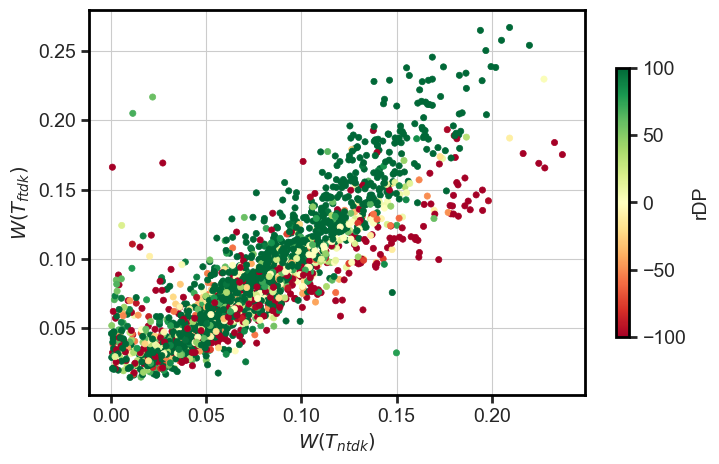

In [10]:
label = "rACC" if met=='acc' else "rDP"
tree_w_cond_dist_no_corr = np.array([v['tree_w_cond_dist_no_corr'] for v in res])
tree_w_cond_dist_alpha_0 = np.array([v['tree_w_cond_dist_alpha_0'] for v in res])
avg_d_att = np.array([v['avg_d_att'] for v in res])
min_d_y_cond = np.array([v['min_d_y_cond'] for v in res])
avg_d_splits = np.array([v['avg_d_splits'] for v in res])
cs = np.array([v['dif'] for v in res])

xs = tree_w_cond_dist_no_corr
ys = tree_w_cond_dist_alpha_0

_, ax = plt.subplots(figsize=(8, 5))
plt.scatter(xs, ys, c=cs, linewidths = .5, marker ="o", cmap="RdYlGn", s=20, norm=TwoSlopeNorm(0, -100, 100))
#ax.plot([0, .25], [0, .25])
plt.colorbar(label=label, orientation="vertical", shrink=0.7)
plt.xlabel('$W(T_{ntdk})$')
plt.ylabel('$W(T_{ftdk})$')
plt.savefig('fig3'+met+'.png', bbox_inches='tight', dpi=400)
plt.show()

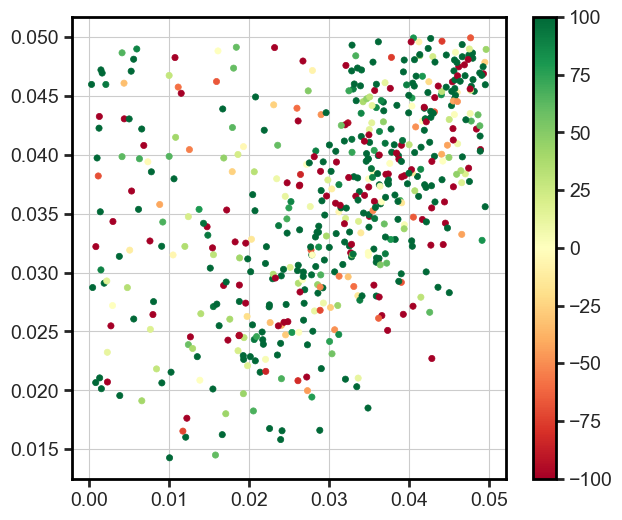

In [11]:
# zoom
pos = np.where( (xs < .05) & (ys < .05) )[0]
#pos = np.where( (ys > xs - 0.03) | (ys < xs + 0.03) )[0]
#pos = np.where( (xs < ys - 0.01) )[0]
xs1 = xs[pos]
ys1 = ys[pos]
cs1 = cs[pos]

_, ax = plt.subplots(figsize=(7, 6))
plt.scatter(xs1, ys1, c=cs1, linewidths = .5, marker ="o", cmap="RdYlGn", s=20, norm=TwoSlopeNorm(0, -100, 100))
plt.colorbar()
plt.show()

37.27696662373705
Ttest_1sampResult(statistic=23.74240738721633, pvalue=2.544102149849698e-112)
33.48105368058313
Ttest_1sampResult(statistic=10.035332975066892, pvalue=7.0972994048069295e-22)


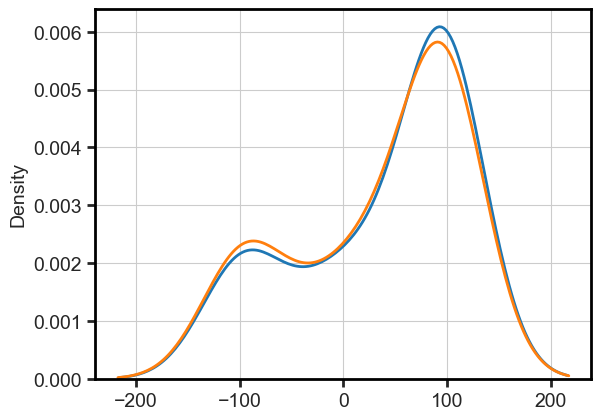

In [12]:
data1 = cs
data1 = data1[~np.isnan(data1)]
print(np.mean(data1))
print(stats.ttest_1samp(data1, popmean=0))
sns.kdeplot(np.array(data1), bw_method=0.5)

data2 = cs1
data2 = data2[~np.isnan(data2)]
print(np.mean(data2))
print(stats.ttest_1samp(data2, popmean=0))
sns.kdeplot(np.array(data2), bw_method=0.5)
plt.show()

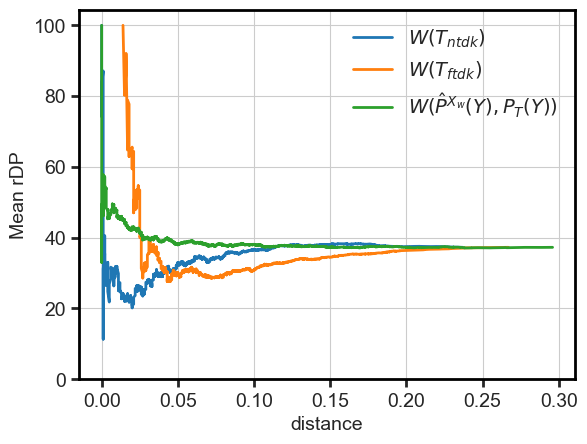

In [13]:
label = "Mean rACC" if met=='acc' else "Mean rDP"

sortby = np.round(tree_w_cond_dist_no_corr, 3)
pos = np.argsort(sortby)
ns = range(1, 1+len(pos))
posf = np.cumsum(cs[pos])/ns
plt.plot(sortby[pos], posf, label='$W(T_{ntdk})$')

sortby = np.round(tree_w_cond_dist_alpha_0, 3)
pos = np.argsort(sortby)
ns = range(1, 1+len(pos))
posf = np.cumsum(cs[pos])/ns
plt.plot(sortby[pos], posf, label='$W(T_{ftdk})$')

sortby = np.round(min_d_y_cond, 3)
pos = np.argsort(sortby)
ns = range(1, 1+len(pos))
posf = np.cumsum(cs[pos])/ns
plt.plot(sortby[pos], posf, label='$W( \hat{P}^{X_w}(Y), P_T(Y) )$')

plt.xlabel('distance')
plt.ylabel(label)
plt.legend(loc='upper right')
plt.ylim(0)
plt.savefig('fig4'+met+'.png', bbox_inches='tight', dpi=400)
plt.show()